# Summary

* Name: `dissipation-theory--Study-4.ipynb`
* Author: John A. Marohn
* Date: 2023-09-25
* Continued from: `dissipation-theory--Study-3.ipynb`
* Continued to: ---
* Look at ways to cut down code redundancy in the code in `dissipation-theory--Study-3.ipynb`.  I would *greatly* simplify my code if the sample object would update the diffusion length automatically when the mobility or cantilever period was updated.

Research the python `@property` decorator.  Some useful discussions:

* https://realpython.com/python-property/
* https://stackoverflow.com/questions/67089941/is-it-worth-using-pythons-property-decorator-if-you-dont-mind-using-a-method

To see what `@property` is doing, compare the following two class definitions.

# `@property` examples

## Example 1

Compute the area of a rectanble using the current values of width and height.  But `width` and `height` are attributes while `area()` is a function.

In [1]:
class Rectangle:
    def __init__(self, width, height):
        self.width = width
        self.height = height

    def area(self):
        return self.width * self.height

To compute the area, we have to call the function `r.area()`.

In [2]:
r = Rectangle(2,3)
r.area()

6

In [3]:
r = Rectangle(2,3)
r.area

<bound method Rectangle.area of <__main__.Rectangle object at 0x10b361670>>

The area is nevertheless computed correctly if we update the height after the object is initialized.

In [4]:
r = Rectangle(2,3)
r.height = 4
r.area()

8

## Example 2

Add the `@property` decorator to the `area` function and now the `area` function not behaves like an attribute.  The function `area()` is called when the programmer asks for the attrubute `area`.

In [5]:
class Rectangle:
    def __init__(self, width, height):
        self.width = width
        self.height = height

    @property
    def area(self):
        return self.width * self.height

To comute the area, we can now just ask for the attribute `r.area`.

In [6]:
r = Rectangle(2,3)
r.area

6

The area is again computed correctly if we update the height after the object is initialized.

In [7]:
r = Rectangle(2,3)
r.height = 4
r.area

8

# Preliminaries

In [8]:
import numpy as np
from dissipationtheory.constants import ureg, epsilon0, qe, kb
import matplotlib.pyplot as plt
from scipy import integrate
from tqdm import tqdm
import pandas as pd

In [9]:
THIS = 'dissipation-theory--Study-4'

# Redefine the sample and cantilever classes 

Redefine the classes to represent the cantilever and the sample using `@property` so that derived quantities, like the diffusion length tnat the Debye length, are computed afresh when you ask for them.

In [10]:
class CantileverModel(object):

    def __init__(self, f_c, V_ts, R, d):

        self.f_c = f_c
        self.V_ts = V_ts
        self.R = R
        self.d = d

    @property
    def omega_c(self):
        return 2 * np.pi * self.f_c

    def __repr__(self):

        str = 'cantilever\n\n'
        str = str + '      resonance freq = {:.3f} kHz\n'.format(self.f_c.to('kHz').magnitude)
        str = str + '                     = {:.3e} rad/s\n'.format(self.omega_c.to('Hz').magnitude)
        str = str + '  tip-sample voltage = {:.3f} V\n'.format(self.V_ts.to('V').magnitude)
        str = str + '              radius = {:.3f} nm\n'.format(self.R.to('nm').magnitude)
        str = str + '              height = {:.3f} nm\n'.format(self.d.to('nm').magnitude)
        
        return str

Define a representative cantilever object.

In [11]:
cantilever = CantileverModel(
    
    f_c = ureg.Quantity(81, 'kHz'),
    V_ts = ureg.Quantity(3, 'V'),
    R = ureg.Quantity(80, 'nm'),
    d = ureg.Quantity(300, 'nm')
)

Ask for $\omega_{\mathrm{c}} = 2 \pi f_{\mathrm{c}}$

In [12]:
cantilever.omega_c

508.93800988154646 <Unit('kilohertz')>

Double $f_{\mathrm{c}}$ and confirm that $\omega_{\mathrm{c}} = 2 \pi f_{\mathrm{c}}$ is now updated appropriately.

In [13]:
cantilever.f_c = ureg.Quantity(162, 'kHz')
cantilever.omega_c

1017.8760197630929 <Unit('kilohertz')>

In [14]:
cantilever

cantilever

      resonance freq = 162.000 kHz
                     = 1.018e+06 rad/s
  tip-sample voltage = 3.000 V
              radius = 80.000 nm
              height = 300.000 nm

Redefine `Sample1` analogously.

In [15]:
class SampleModel1(object):
    
    def __init__(self, cantilever, h_s, epsilon_s, mu, rho, epsilon_d, z_r):

        self.cantilever = cantilever
        self.epsilon_s = epsilon_s
        self.h_s = h_s
        self.mu = mu
        self.rho = rho
        self.epsilon_d = epsilon_d
        self.z_r = z_r

    @property
    def D(self):
        return ((kb * ureg.Quantity(300., 'K') * self.mu) / qe).to('m^2/s')

    @property
    def Ld(self):
        return (np.sqrt(self.D / self.cantilever.omega_c)).to('nm')
    
    @property
    def LD(self):
        return (np.sqrt((epsilon0 * kb * ureg.Quantity(300., 'K'))/(self.rho * qe * qe))).to('nm')

    @property
    def epsilon_eff(self):
        return (self.epsilon_s - complex(0,1) * self.Ld**2 / self.LD**2).to_base_units()

    def __repr__(self):

        str = self.cantilever.__repr__()
        str = str + '\nsemiconductor\n\n'
        str = str + '             epsilon (real) = {:0.3f}\n'.format(self.epsilon_s.to('').real.magnitude)
        str = str + '             epsilon (imag) = {:0.3f}\n'.format(self.epsilon_s.to('').imag.magnitude)
        str = str + '                  thickness = {:.3} nm\n'.format(self.h_s.to('nm').magnitude)
        str = str + '                   mobility = {:0.3e} m^2/(V s)\n'.format(self.mu.to('m^2/(V s)').magnitude)
        str = str + '         diffusion constant = {:0.3e} m^2/s\n'.format(self.D.to('m^2/s').magnitude)
        str = str + '             charge density = {:0.3e} m^{{-3}}\n'.format(self.rho.to('1/m^3').magnitude)
        str = str + '           reference height = {:0.3e} nm\n'.format(self.z_r.to('nm').magnitude)
        str = str + '               Debye length = {:0.3e} nm\n'.format(self.LD.to('nm').magnitude)
        str = str + '           diffusion length = {:0.3e} nm\n'.format(self.Ld.to('nm').magnitude)
        str = str + '   effective epsilon (real) = {:0.3f}\n'.format(self.epsilon_eff.to('').real.magnitude)
        str = str + '   effective epsilon (imag) = {:0.3f}\n\n'.format(self.epsilon_eff.to('').imag.magnitude)
        str = str + 'dielectric\n\n'
        str = str + '  epsilon (real) = {:0.3f}\n'.format(self.epsilon_d.to('').real.magnitude)
        str = str + '  epsilon (imag) = {:0.3f}\n'.format(self.epsilon_d.to('').imag.magnitude)
        str = str + '       thickness = infinite'
        
        return str

In [16]:
sample1 = SampleModel1(

    cantilever = CantileverModel(
        f_c = ureg.Quantity(81.01, 'kHz'), 
        V_ts = ureg.Quantity(3.01, 'V'), 
        R = ureg.Quantity(80.01, 'nm'), 
        d = ureg.Quantity(300.01, 'nm')),
    h_s = ureg.Quantity(1e6, 'nm'),
    epsilon_s = ureg.Quantity(complex(11.9, -0.05), ''),
    mu = ureg.Quantity(1e-5, 'm^2/(V s)'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(11.9, -0.05), ''),
    z_r = ureg.Quantity(100, 'nm')
)

In [17]:
sample1

cantilever

      resonance freq = 81.010 kHz
                     = 5.090e+05 rad/s
  tip-sample voltage = 3.010 V
              radius = 80.010 nm
              height = 300.010 nm

semiconductor

             epsilon (real) = 11.900
             epsilon (imag) = -0.050
                  thickness = 1e+06 nm
                   mobility = 1.000e-05 m^2/(V s)
         diffusion constant = 2.585e-07 m^2/s
             charge density = 1.000e+21 m^{-3}
           reference height = 1.000e+02 nm
               Debye length = 3.780e+01 nm
           diffusion length = 7.127e+02 nm
   effective epsilon (real) = 11.900
   effective epsilon (imag) = -355.553

dielectric

  epsilon (real) = 11.900
  epsilon (imag) = -0.050
       thickness = infinite

Print out the diffusion constant `D` and diffusion length `Ld`.

In [18]:
(sample1.D, sample1.Ld)

(2.5851999850977736e-07 <Unit('meter ** 2 / second')>,
 712.6689245796254 <Unit('nanometer')>)

Increase the mobility by a factor of $10^{2}$ and observe that `D` increases by $10^{2}$ and `Ld` decreases by $10^{1}$.

In [19]:
sample1.mu = ureg.Quantity(1e-3, 'm^2/(V s)')
(sample1.D, sample1.Ld)

(2.585199985097773e-05 <Unit('meter ** 2 / second')>,
 7126.689245796252 <Unit('nanometer')>)

Decrease the cantilever resonance frequency by $4$-fold and obseve that the diffusion length `Ld` increases by $2$-fold.

In [20]:
sample1.cantilever.f_c =  ureg.Quantity(40.5, 'kHz')
(sample1.D, sample1.Ld)

(2.585199985097773e-05 <Unit('meter ** 2 / second')>,
 10079.282706565251 <Unit('nanometer')>)

In [21]:
sample1

cantilever

      resonance freq = 40.500 kHz
                     = 2.545e+05 rad/s
  tip-sample voltage = 3.010 V
              radius = 80.010 nm
              height = 300.010 nm

semiconductor

             epsilon (real) = 11.900
             epsilon (imag) = -0.050
                  thickness = 1e+06 nm
                   mobility = 1.000e-03 m^2/(V s)
         diffusion constant = 2.585e-05 m^2/s
             charge density = 1.000e+21 m^{-3}
           reference height = 1.000e+02 nm
               Debye length = 3.780e+01 nm
           diffusion length = 1.008e+04 nm
   effective epsilon (real) = 11.900
   effective epsilon (imag) = -71109.410

dielectric

  epsilon (real) = 11.900
  epsilon (imag) = -0.050
       thickness = infinite

In [22]:
class SampleModel2(object):
    
    def __init__(self, cantilever, epsilon_d, h_d, epsilon_s, mu, rho, z_r):

        self.cantilever = cantilever
        self.epsilon_d = epsilon_d
        self.h_d = h_d
        self.epsilon_s = epsilon_s
        self.mu = mu
        self.rho = rho
        self.z_r = z_r

    @property
    def D(self):
        return ((kb * ureg.Quantity(300., 'K') * self.mu) / qe).to('m^2/s')

    @property
    def Ld(self):
        return (np.sqrt(self.D / self.cantilever.omega_c)).to('nm')
    
    @property
    def LD(self):
        return (np.sqrt((epsilon0 * kb * ureg.Quantity(300., 'K'))/(self.rho * qe * qe))).to('nm')

    @property
    def epsilon_eff(self):
        return (self.epsilon_s - complex(0,1) * self.Ld**2 / self.LD**2).to_base_units()

    def __repr__(self):

        str = self.cantilever.__repr__()
        str = str + '\ndielectric\n\n'
        str = str + '  epsilon (real) = {:0.3f}\n'.format(self.epsilon_d.to('').real.magnitude)
        str = str + '  epsilon (imag) = {:0.3f}\n'.format(self.epsilon_d.to('').imag.magnitude)
        str = str + '       thickness = {:.1f} nm\n\n'.format(self.h_d.to('nm').magnitude)
        str = str + 'semiconductor\n\n'
        str = str + '             epsilon (real) = {:0.3f}\n'.format(self.epsilon_s.to('').real.magnitude)
        str = str + '             epsilon (imag) = {:0.3f}\n'.format(self.epsilon_s.to('').imag.magnitude)
        str = str + '                  thickness = infinite\n'
        str = str + '                   mobility = {:0.2e} m^2/(V s)\n'.format(self.mu.to('m^2/(V s)').magnitude)
        str = str + '         diffusion constant = {:0.2e} m^2/s\n'.format(self.D.to('m^2/s').magnitude)
        str = str + '             charge density = {:0.2e} m^{{-3}}\n'.format(self.rho.to('1/m^3').magnitude)
        str = str + '           reference height = {:0.1f} nm\n'.format(self.z_r.to('nm').magnitude)
        str = str + '               Debye length = {:0.1f} nm\n'.format(self.LD.to('nm').magnitude)
        str = str + '           diffusion length = {:0.1f} nm\n'.format(self.Ld.to('nm').magnitude)
        str = str + '   effective epsilon (real) = {:0.3f}\n'.format(self.epsilon_eff.to('').real.magnitude)
        str = str + '   effective epsilon (imag) = {:0.3f}\n\n'.format(self.epsilon_eff.to('').imag.magnitude)

        return str

# Utility hyperbolic functions

Define my own `sech(x)` and `csch(x)` functions that return 0 for large `x`, avoiding overflow problems.  See the StackOverflow discussion "Overflow in Numpy Cosh Function" ([link](https://stackoverflow.com/questions/31889801/overflow-in-numpy-cosh-function)).  Define the functions so they work on both numbers and numpy arrays.  

In [23]:
def mysech(x):
    
    x = np.array(x)
    mask = abs(x.real) < 710.4
    values = np.zeros_like(x, dtype=complex)
    values[mask] = 1/np.cosh(x[mask])
    
    return values

In [24]:
def mycsch(x):
    
    x = np.array(x)
    mask = abs(x.real) < 710.4
    values = np.zeros_like(x, dtype=complex)
    values[mask] = 1/np.sinh(x[mask])
    
    return values

# Capacitance over a semiconductor substrate

In [25]:
from sympy import symbols, acosh, sinh, lambdify

In [26]:
height, R, power = symbols("d R n")
CsphereOverSemiTermSymbolic = {}
CsphereOverSemiTermSymbolic[0] = (
    R * sinh(acosh(1 + height / R)) / sinh(power * acosh(1 + height / R))
)
CsphereOverSemiTermSymbolic[1] = CsphereOverSemiTermSymbolic[0].diff(height)
CsphereOverSemiTermSymbolic[2] = CsphereOverSemiTermSymbolic[0].diff(height).diff(height)

CsphereOverSemiTerm = {}
for key in CsphereOverSemiTermSymbolic.keys():
    CsphereOverSemiTerm[key] = lambdify([height, R, power], CsphereOverSemiTermSymbolic[key])

def CsphereOverSemi(index, height, radius, epsilon, nterm=21):
    """Capacitance (and derivatives) of a sphere above a semiconductor.

    :param integer index: 0 for capacitance, 1 for 1st derivative, 2 for 2nd derivative
    :param pint.util.Quantity height: sphere-to-plane separation
    :param pint.util.Quantity radius: sphere radius
    :param float: real part of the semiconductor's dielectric constant
    :param int nterm: number of terms in the expansion

    """
    H = ureg.Quantity(np.outer(height.magnitude, np.ones(nterm)), height.units)
    n = np.outer(np.ones(len(height)), np.arange(1, nterm + 1))
    return (
        4
        * np.pi
        * epsilon0
        * (np.power((1 - (1 / epsilon))/(1 + (1 / epsilon)), n - 1) * \
          CsphereOverSemiTerm[index](H, radius, n)).sum(axis=1).to_base_units()
    )

# Sample 1 integrand

In [99]:
sample1 = SampleModel1(

    cantilever = CantileverModel(
        f_c = ureg.Quantity(81, 'kHz'), 
        V_ts = ureg.Quantity(3, 'V'), 
        R = ureg.Quantity(80, 'nm'), 
        d = ureg.Quantity(300, 'nm')),
    h_s = ureg.Quantity(3000., 'nm'),
    epsilon_s = ureg.Quantity(complex(11.9, -0.05), ''),
    mu = ureg.Quantity(2.7E-10, 'm^2/(V s)'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    epsilon_d = ureg.Quantity(complex(11.9, -0.05), ''),
    z_r = ureg.Quantity(300, 'nm')
)

In [100]:
sample1

cantilever

      resonance freq = 81.000 kHz
                     = 5.089e+05 rad/s
  tip-sample voltage = 3.000 V
              radius = 80.000 nm
              height = 300.000 nm

semiconductor

             epsilon (real) = 11.900
             epsilon (imag) = -0.050
                  thickness = 3e+03 nm
                   mobility = 2.700e-10 m^2/(V s)
         diffusion constant = 6.980e-12 m^2/s
             charge density = 1.000e+21 m^{-3}
           reference height = 3.000e+02 nm
               Debye length = 3.780e+01 nm
           diffusion length = 3.703e+00 nm
   effective epsilon (real) = 11.900
   effective epsilon (imag) = -0.060

dielectric

  epsilon (real) = 11.900
  epsilon (imag) = -0.050
       thickness = infinite

Code from the last study, rewritten for clarity.

In [101]:
def theta1norm(omega, sample, power):

    r1 = sample.Ld**2 / (sample.epsilon_s * sample.LD**2)
    r2 = sample.z_r**2 / (sample.epsilon_s * sample.LD**2)
    r3 = sample.z_r**2 / sample.Ld**2
    lambduh = (complex(0,1) * r1 * omega / np.sqrt(omega**2 + r2 + complex(0,1) * r3)).to('dimensionless').magnitude
     
    khs = (omega * sample.h_s / sample.z_r).to('dimensionless').magnitude

    r1 = sample.h_s**2 / sample.z_r**2
    r2 = sample.h_s**2 / (sample.epsilon_s * sample.LD**2)
    r3 = sample.h_s**2 / sample.Ld**2
    etahs = (np.sqrt(r1 * omega**2 + r2 + complex(0,1) * r3)).to('dimensionless').magnitude

    alpha = (sample.epsilon_eff/sample.epsilon_d).to('').magnitude
    
    r1 = 1/sample.epsilon_eff
    t1 = - lambduh / np.tanh(etahs)
    t2 = np.tanh(khs) * np.tanh(etahs) \
         + alpha * np.tanh(etahs) \
         - lambduh \
         + 2 * lambduh * mysech(khs) * mysech(etahs) \
         - lambduh**2 * np.tanh(khs) * mysech(etahs) * mycsch(etahs)
    t3 = np.tanh(etahs) \
         + np.tanh(khs) * (-1 * lambduh + alpha * np.tanh(etahs))

    theta = (r1 * (t1 + t2 / t3)).to('dimensionless').magnitude

    ratio = (1 - theta) / (1 + theta)
    exponent = (2 * sample.cantilever.d / sample.z_r).to('dimensionless').magnitude

    integrand = omega**power * np.exp(-1 * omega * exponent) * np.imag(ratio)

    return integrand

In [102]:
def C(power, theta, sample):
    
    prefactor = (-1**(power + 1) * kb * ureg.Quantity(300., 'K')) / \
          (4 * np.pi * epsilon0 * sample.cantilever.omega_c * sample.z_r**(power+1))
    
    integral = integrate.quad(theta, 0., np.inf, args=(sample, power))[0]
    
    return (prefactor * 0.50 * integral).to_base_units()

In [103]:
def gamma_parallel(theta, sample):

    prefactor = (sample.cantilever.V_ts**2 / (kb * ureg.Quantity(300., 'K'))).to('V/C')
    
    c0 = CsphereOverSemi(index=0, 
            height=sample.cantilever.d * np.ones(1), 
            radius=sample.cantilever.R, 
            epsilon=sample.epsilon_d.real.magnitude)

    return prefactor * c0 * c0 * C(2, theta, sample)

Loop over charge densities and compute the integral.

In [104]:
rho1_ = ureg.Quantity(np.logspace(start=15, stop=29, num=50), '1/m^3')
gamma1 = ureg.Quantity(np.zeros_like(rho1_), 'pN s/m')

for index, rho__ in enumerate(rho1_):

    sample1.rho = rho__
    gamma1[index] = gamma_parallel(theta1norm, sample1)

# Sample 2 integrand

In [105]:
sample2 = SampleModel2(

    cantilever = CantileverModel(
        f_c = ureg.Quantity(81, 'kHz'), 
        V_ts = ureg.Quantity(3, 'V'), 
        R = ureg.Quantity(80, 'nm'), 
        d = ureg.Quantity(300, 'nm')),
    h_d = ureg.Quantity(0., 'nm'),
    epsilon_d = ureg.Quantity(complex(11.9, -0.05), ''),
    epsilon_s = ureg.Quantity(complex(11.9, -0.05), ''),
    mu = ureg.Quantity(2.7e-10, 'm^2/(V s)'),
    rho = ureg.Quantity(1e21, '1/m^3'),
    z_r = ureg.Quantity(300, 'nm')
)

In [106]:
sample2

cantilever

      resonance freq = 81.000 kHz
                     = 5.089e+05 rad/s
  tip-sample voltage = 3.000 V
              radius = 80.000 nm
              height = 300.000 nm

dielectric

  epsilon (real) = 11.900
  epsilon (imag) = -0.050
       thickness = 0.0 nm

semiconductor

             epsilon (real) = 11.900
             epsilon (imag) = -0.050
                  thickness = infinite
                   mobility = 2.70e-10 m^2/(V s)
         diffusion constant = 6.98e-12 m^2/s
             charge density = 1.00e+21 m^{-3}
           reference height = 300.0 nm
               Debye length = 37.8 nm
           diffusion length = 3.7 nm
   effective epsilon (real) = 11.900
   effective epsilon (imag) = -0.060


In [107]:
def theta2norm(omega, sample, power):

    r1 = sample.Ld**2 / (sample.epsilon_s * sample.LD**2)
    r2 = sample.z_r**2 / (sample.epsilon_s * sample.LD**2)
    r3 = sample.z_r**2 / sample.Ld**2
    lambduh = (complex(0,1) * r1 * omega / np.sqrt(omega**2 + r2 + complex(0,1) * r3)).to('dimensionless').magnitude
     
    khd = (omega * sample.h_d / sample.z_r).to('dimensionless').magnitude

    r1 = 1/sample.epsilon_d
    t1 = sample.epsilon_eff * np.tanh(khd) + (1 - lambduh) * sample.epsilon_d
    t2 = sample.epsilon_eff + (1 - lambduh) * sample.epsilon_d * np.tanh(khd)

    theta = ((r1 * t1) / t2).magnitude

    ratio = (1 - theta) / (1 + theta)
    exponent = (2 * sample.cantilever.d / sample.z_r).to('dimensionless').magnitude

    integrand = omega**power * np.exp(-1 * omega * exponent) * np.imag(ratio) 

    return integrand

In [139]:
rho2_ = ureg.Quantity(np.logspace(start=15, stop=29, num=55), '1/m^3')
gamma2 = ureg.Quantity(np.zeros_like(rho2_), 'pN s/m')

for index, rho__ in enumerate(rho2_):

    sample2.rho = rho__
    gamma2[index] = gamma_parallel(theta2norm, sample2)

# Compare integrals

In [140]:
keys = ['1.5e-01','4.0e-07','2.7e-10','6.0e-14']

names = ['Lekkala2013--Fig7b--1.5e-01.csv', 
         'Lekkala2013--Fig7b--4.0e-07.csv',
         'Lekkala2013--Fig7b--2.7e-10.csv',
         'Lekkala2013--Fig7b--6.0e-14.csv']

Figure7b_original = {}
for key, name in zip(keys, names):
    Figure7b_original[key] = pd.read_csv(name, names=['rho', 'gamma'])

In [141]:
def gamma_max_eq29(sample):

    c0 = CsphereOverSemi(index=0, 
        height=sample.cantilever.d * np.ones(1), 
        radius=sample.cantilever.R, 
        epsilon=sample.epsilon_s.real.magnitude)

    qs = c0 * sample.cantilever.V_ts
    prefactor = 0.25 * (sample.epsilon_s.real**2)/(sample.epsilon_s.real**2 + sample.epsilon_s.imag**2)
    
    return (prefactor * qs * qs / (4 * np.pi * epsilon0 * sample.cantilever.omega_c * sample.cantilever.d**3)).to('pN s/m')


In [142]:
def gamma_max_eq28(sample):

    c0 = CsphereOverSemi(index=0, 
        height=sample.cantilever.d * np.ones(1), 
        radius=sample.cantilever.R, 
        epsilon=sample.epsilon_s.real.magnitude)
    
    qs = c0 * sample.cantilever.V_ts
    prefactor = (sample.epsilon_s.real**2 + sample.epsilon_s.imag**2)/(1 + sample.epsilon_s.real)**2
    
    return (prefactor * qs * qs / (4 * np.pi * epsilon0 * sample.cantilever.omega_c * sample.cantilever.d**3)).to('pN s/m')

Check on the semiconductor layers' dielectric constant

In [143]:
sample2.epsilon_s.to('dimensionless').magnitude

(11.9-0.05j)

Evaluate the three critical densities in Equations 24 through 28 in Lekkala2013.

In [144]:
def densities(sample):

    rho_x = ((sample.cantilever.omega_c * epsilon0)/(qe * sample.mu)).to('1/m^3').magnitude

    r3 = ((-1 * sample.epsilon_s.imag)/(sample.epsilon_s.real**2 + sample.epsilon_s.imag**2)).to('dimensionless').magnitude
    r2  = ((sample.epsilon_s.real**2 + sample.epsilon_s.imag**2)/sample.epsilon_s.real).to('dimensionless').magnitude
    r1 = ((np.power(np.abs(sample.epsilon_s), 4.0) * sample.cantilever.omega_c * sample.cantilever.d**2)/ \
         (sample.epsilon_s.imag**2 * sample.D)).to('dimensionless').magnitude
    
    return r3 * rho_x, r2 * rho_x, r1 * rho_x

In [145]:
rho3crit, rho2crit, rho1crit = densities(sample2)
(rho3crit, rho2crit, rho1crit)

(3.677967394358782e+19, 1.2396357394603841e+24, 5.483427667529384e+33)

A function encoding the approximate results in Equations 28 through 30 in Lakkala2013.

In [146]:
def approx1(rho, sample, rho3crit, rho2crit, rho1crit):

    c0 = CsphereOverSemi(index=0, 
        height=sample.cantilever.d * np.ones(1), 
        radius=sample.cantilever.R, 
        epsilon=sample.epsilon_s.real.magnitude)
    
    qc = c0 * sample.cantilever.V_ts

    gamma = ureg.Quantity(np.zeros(len(rho)), 'pN s/m')
    mask = np.zeros(len(rho), dtype=bool)
    
    for index, rho_ in enumerate(rho):

        sample.rho = rho_
        
        if (rho_.to('1/m^3').magnitude > rho3crit) and (rho_.to('1/m^3').magnitude <= rho2crit): 

            f1 = (qc * qc)/(4 * np.pi * epsilon0 * sample.cantilever.omega_c**2)
            f2 = sample.epsilon_s.real/(1 + sample.epsilon_s.real)**2
            f3 = sample.D/(sample.LD**2 * sample.cantilever.d**3)
    
            gamma[index] = f1 * f2 * f3
            mask[index] = True

        if (rho_.to('1/m^3').magnitude > rho2crit) and (rho_.to('1/m^3').magnitude <= rho1crit): 

            f1 = (qc * qc)/(16 * np.pi * epsilon0)
            f2 = (sample.epsilon_s.real * sample.LD ** 2)/(sample.D * sample.cantilever.d**3)

            gamma[index] = f1 * f2
            mask[index] = True
    
    return rho.to('1/m^3')[mask], gamma.to('pN s/m')[mask]

In [147]:
rho_approx1_ = ureg.Quantity(
    np.logspace(
        start=np.log10(min(rho1_.to('1/m^3').magnitude)), 
        stop=np.log10(rho1crit), num=100), 
    '1/m^3')

rho_approx1_, approx1_ = approx1(rho_approx1_, sample2, rho3crit, rho2crit, rho1crit)

An approximation that I have derived.

In [148]:
def approx2(rho, sample, rho3crit, rho2crit, rho1crit):

    c0 = CsphereOverSemi(index=0, 
        height=sample.cantilever.d * np.ones(1), 
        radius=sample.cantilever.R, 
        epsilon=sample.epsilon_s.real.magnitude)
    
    qc = c0 * sample.cantilever.V_ts

    gamma = ureg.Quantity(np.zeros(len(rho)), 'pN s/m')
    mask = np.zeros(len(rho), dtype=bool)
    
    for index, rho_ in enumerate(rho):

        sample.rho = rho_

        if (rho_.to('1/m^3').magnitude <= rho2crit):

            t1 = - sample.epsilon_s.imag/(np.abs(sample.epsilon_s + 1)**2)
            t2 = (qc * qc)/(16 * np.pi * epsilon0 * sample.cantilever.omega_c * sample.cantilever.d**3)

            t3 =  (qc * qc)/(16 * np.pi * epsilon0 * sample.cantilever.omega_c**2)
            t4 = ((1 + sample.epsilon_s.real)**2 - (sample.epsilon_s.imag)**2)/(np.abs(sample.epsilon_s + 1)**4)
            t5 = sample.D/(sample.LD**2 * sample.cantilever.d**3)

            gamma[index] = t1 * t2 + t3 * t4 * t5
            mask[index] = True            

        if (rho_.to('1/m^3').magnitude > rho2crit):

            t1 = (3 * qc * qc)/(32 * epsilon0 * sample.cantilever.omega_c * sample.cantilever.d**4)
            t2 = (np.sqrt(np.conjugate(sample.epsilon_s))).imag/np.abs(sample.epsilon_s)
            t3 = sample.LD

            t4 = (qc * qc * sample.LD**2)/(2 * np.pi * epsilon0 * sample.cantilever.d**3 * sample.D)

            gamma[index] = t1 *t2 * t3 + t4
            mask[index] = True
    
    return rho.to('1/m^3')[mask], gamma.to('pN s/m')[mask]

In [149]:
rho_approx2_ = ureg.Quantity(
    np.logspace(
        start=np.log10(min(rho1_.to('1/m^3').magnitude)), 
        stop=np.log10(rho1crit), num=100), 
    '1/m^3')

rho_approx2_, approx2_ = approx2(rho_approx2_, sample2, rho3crit, rho2crit, rho1crit)

An array of the approximate friction:

Plot everything up.

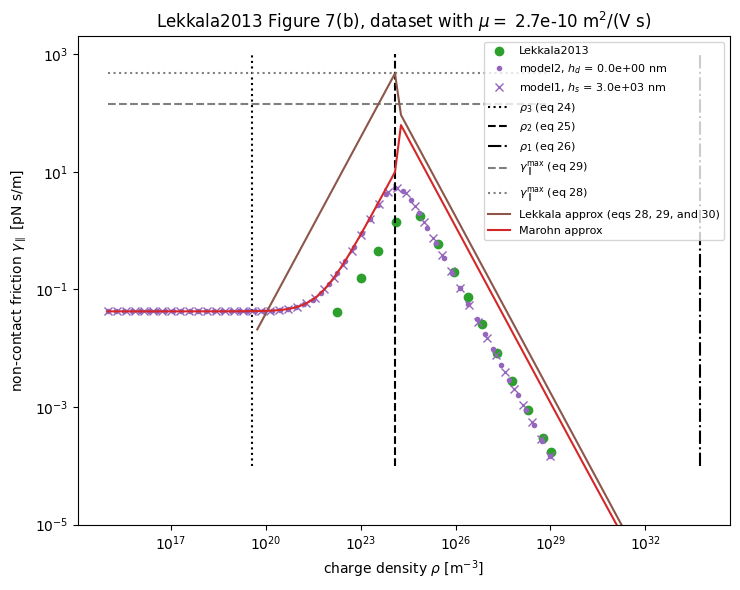

In [154]:
plt.figure(figsize=(7.50, 6.00))

plt.loglog(Figure7b_original['2.7e-10']['rho'],
           Figure7b_original['2.7e-10']['gamma'], 
           'o', 
           color = 'tab:green',
           label='Lekkala2013')

plt.loglog(rho2_.to('1/m^3').magnitude,
           gamma2.to('pN s/m').magnitude, 
           '.', 
           color = 'tab:purple',
           label='model2, $h_d$ = {:0.1e} nm'.format(sample2.h_d.to('nm').magnitude))

plt.loglog(rho1_.to('1/m^3').magnitude, 
           gamma1.to('pN s/m').magnitude, 
           'x', 
           color = 'tab:purple',
           label='model1, $h_s$ = {:0.1e} nm'.format(sample1.h_s.to('nm').magnitude))

plt.vlines(rho3crit, ymin=1e-4, ymax=1e3, colors='k', linestyle='dotted', label=r'$\rho_3$ (eq 24)')
plt.vlines(rho2crit, ymin=1e-4, ymax=1e3, colors='k', linestyle='dashed', label=r'$\rho_2$ (eq 25)')
plt.vlines(rho1crit, ymin=1e-4, ymax=1e3, colors='k', linestyle='dashdot', label=r'$\rho_1$ (eq 26)')

plt.loglog(rho1_.to('1/m^3').magnitude,
           (gamma_max_eq29(sample2) * np.ones(len(rho1_))).to('pN s/m').magnitude,
           linestyle='dashed',
           color='tab:grey',
           label='$\gamma_{\parallel}^{\mathrm{max}}$ (eq 29)')

plt.loglog(rho1_.to('1/m^3').magnitude,
           (gamma_max_eq28(sample2) * np.ones(len(rho1_))).to('pN s/m').magnitude,
           linestyle='dotted',
           color= 'tab:grey',
           label='$\gamma_{\parallel}^{\mathrm{max}}$ (eq 28)')

plt.loglog(rho_approx1_.to('1/m^3').magnitude, 
           approx1_.to('pN s/m').magnitude,
           '-', 
           color='tab:brown', 
           label='Lekkala approx (eqs 28, 29, and 30)')

plt.loglog(rho_approx2_.to('1/m^3').magnitude, 
           approx2_.to('pN s/m').magnitude,
           '-', 
           color='tab:red', 
           label='Marohn approx')

plt.title('Lekkala2013 Figure 7(b), dataset with $\mu =$ {:0.1e} m$^2$/(V s)'.format(sample2.mu.to('m^2/(V s)').magnitude))
plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('non-contact friction $\gamma_{\parallel}$ [pN s/m]')
plt.legend(fontsize=8, loc=1)
plt.tight_layout()
plt.ylim([1e-5,2e3])

plt.savefig(THIS + '--Fig-Lekkala2023-Fig-7b3.png', dpi=300)
plt.savefig(THIS + '--Fig-Lekkala2023-Fig-7b3.pdf')

plt.show() 